In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('si_lgray_ucondensed')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [10]:
def jhelum_dist(phi1, d0=13, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

wangle = 180*u.deg

In [11]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [14]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [15]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [16]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

### Map

In [71]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)

In [79]:
bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5

bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])

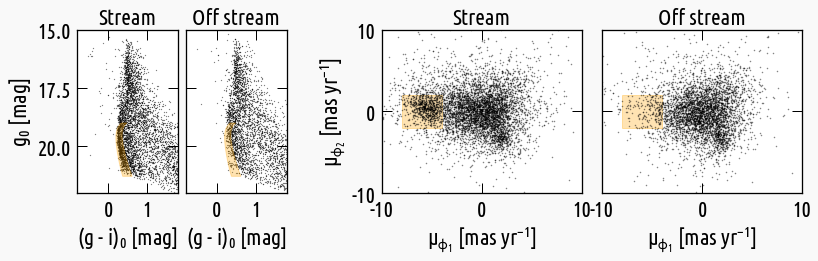

In [119]:
fig = plt.figure(figsize=(13,3))
outer_grid = mpl.gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.35, width_ratios=[1,2])

inner_grid = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[0], 
                                                  wspace=0.07, hspace=0.05)

gax = plt.Subplot(fig, inner_grid[0])
ax0 = fig.add_subplot(gax)

plt.plot(g.g0[phi2_mask & pm_mask] - g.i0[phi2_mask & pm_mask], g.g0[phi2_mask & pm_mask], 
         'ko', ms=0.2, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# rect_xy = [bhb_gi_min, bhb_g_min]
# rect_w = bhb_gi_max - bhb_gi_min
# rect_h = bhb_g_max - bhb_g_min
# pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
# plt.gca().add_artist(pr_bhb)

# pbs = mpl.patches.Polygon(poly_bs, color='pink', alpha=0.3, zorder=2, label='')
# plt.gca().add_artist(pbs)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')
plt.title('Stream', fontsize='medium')

gax = plt.Subplot(fig, inner_grid[1])
ax = fig.add_subplot(gax, sharey=ax0)

plt.plot(g.g0[phi2off_mask & pm_mask] - g.i0[phi2off_mask & pm_mask], g.g0[phi2off_mask & pm_mask], 
         'ko', ms=0.2, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel('(g - i)$_0$ [mag]')
# plt.ylabel('g [mag]')
plt.title('Off stream', fontsize='medium')

inner_grid = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[1], 
                                                  wspace=0.1, hspace=0.05)

gax = plt.Subplot(fig, inner_grid[0])
ax = fig.add_subplot(gax)

plt.plot(cj.pm_phi1_cosphi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Stream', fontsize='medium')

gax = plt.Subplot(fig, inner_grid[1])
ax = fig.add_subplot(gax, sharey=ax0)

plt.plot(cj.pm_phi1_cosphi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[phi2off_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.setp(ax.get_yticklabels(), visible=False)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
# plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Off stream', fontsize='medium')
plt.savefig('../plots/halos/jhelum_selection.png', dpi=200)

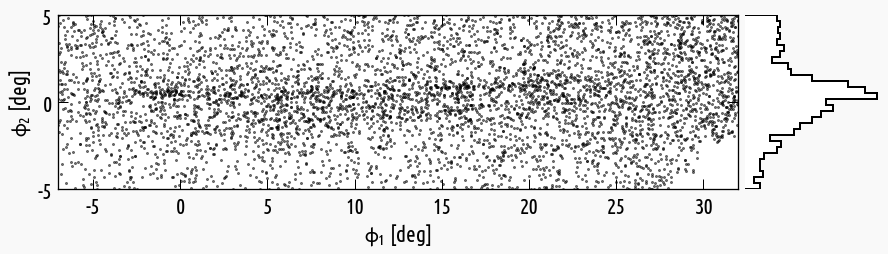

In [112]:
fig, ax = plt.subplots(1,2,figsize=(13,4), gridspec_kw = {'width_ratios':[5,1]}, sharey='row')
plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=4, alpha=0.5)

plt.ylim(-5,5)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
bins = np.linspace(-5,5,30)
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='stepfilled', lw=2, normed=True, color='w', orientation='horizontal')
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='step', lw=2, normed=True, color='k', orientation='horizontal')
plt.xlim(0.03,0.23)
plt.axis('off')
plt.tight_layout(w_pad=0.)
plt.savefig('../plots/halos/jhelum_map.png', dpi=200)

### Galactocentric coordinates

In [26]:
import gala.dynamics as gd
import gala.potential as gp

In [29]:
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)


In [18]:
cgal = cj_dist.transform_to(coord.Galactocentric)
R = np.sqrt(cgal.y**2 + cgal.x**2)

In [45]:
pos = np.load('../data/jhelum_orbit.npy')

In [68]:
phi1, phi2, d, pm1, pm2, vr = pos

c = Jhelum(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

orbit_rr = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-5000*u.Myr)
orbit_fwd = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=5000*u.Myr)

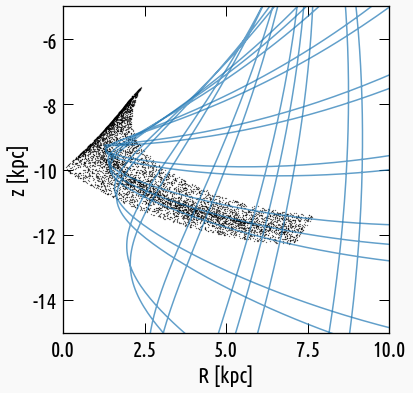

In [69]:
plt.figure(figsize=(6,6))

plt.plot(R[pm_mask & cmd_mask], cgal.z[pm_mask & cmd_mask], 'k.', ms=0.5)
for orbit in [orbit_rr, orbit_fwd]:
    plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.7)

plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,10)
plt.ylim(-15,-5)
plt.gca().set_aspect('equal')
plt.savefig('../plots/halos/cylindrical_orbit.png', dpi=200)
# plt.savefig('../plots/halos/cylindrical_orbit.svg')